# Kaggle House Price Prediction Competition 
## Ensemble Regressions: StackedRegressor from mlxtend with Feature Engineering 
* This is my first Kaggle competition and got a lot of help and idea's from other's notesbooks. 
* [Kaggle Competition Link](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
* Inspired by [Serigne](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard?fbclid=IwAR2njt-MxaSsIJ0zED_VdPdgs_ZdgA_Th8meaOBtjWuS8qMJtzDJ754eo94) and [Laurenstc](https://www.kaggle.com/laurenstc/top-2-of-leaderboard-advanced-fe/notebook?fbclid=IwAR0PHkeKShKgqEJjxXw4_X7FptfMW1Iz59Gi74O-fYqJG_-naQh04oceRZ8)'s notebook

### First Section Contains
* feature engineering
* Outlier removal using PyOD
    * I'm not an expert with house prices so lets use some sort of unsupervised technique to identify the outliers
    
### Second Section
* prediction methods 
* Tuning models using GridsearchCV
* ensemble voting and stacking

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import datetime
from collections import OrderedDict
from scipy import stats
import corner
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import norm, skew

from matplotlib.pyplot import figure

plt.style.use('seaborn')
%matplotlib inline


# Section 1: Feature Engineering

In [2]:
test = pd.read_csv("test.csv")
print(len(test))
train = pd.read_csv("train.csv")
print(len(train))

1459
1460


# We suppose there are some outliers in the data and most likely around the GrLivArea > 4500

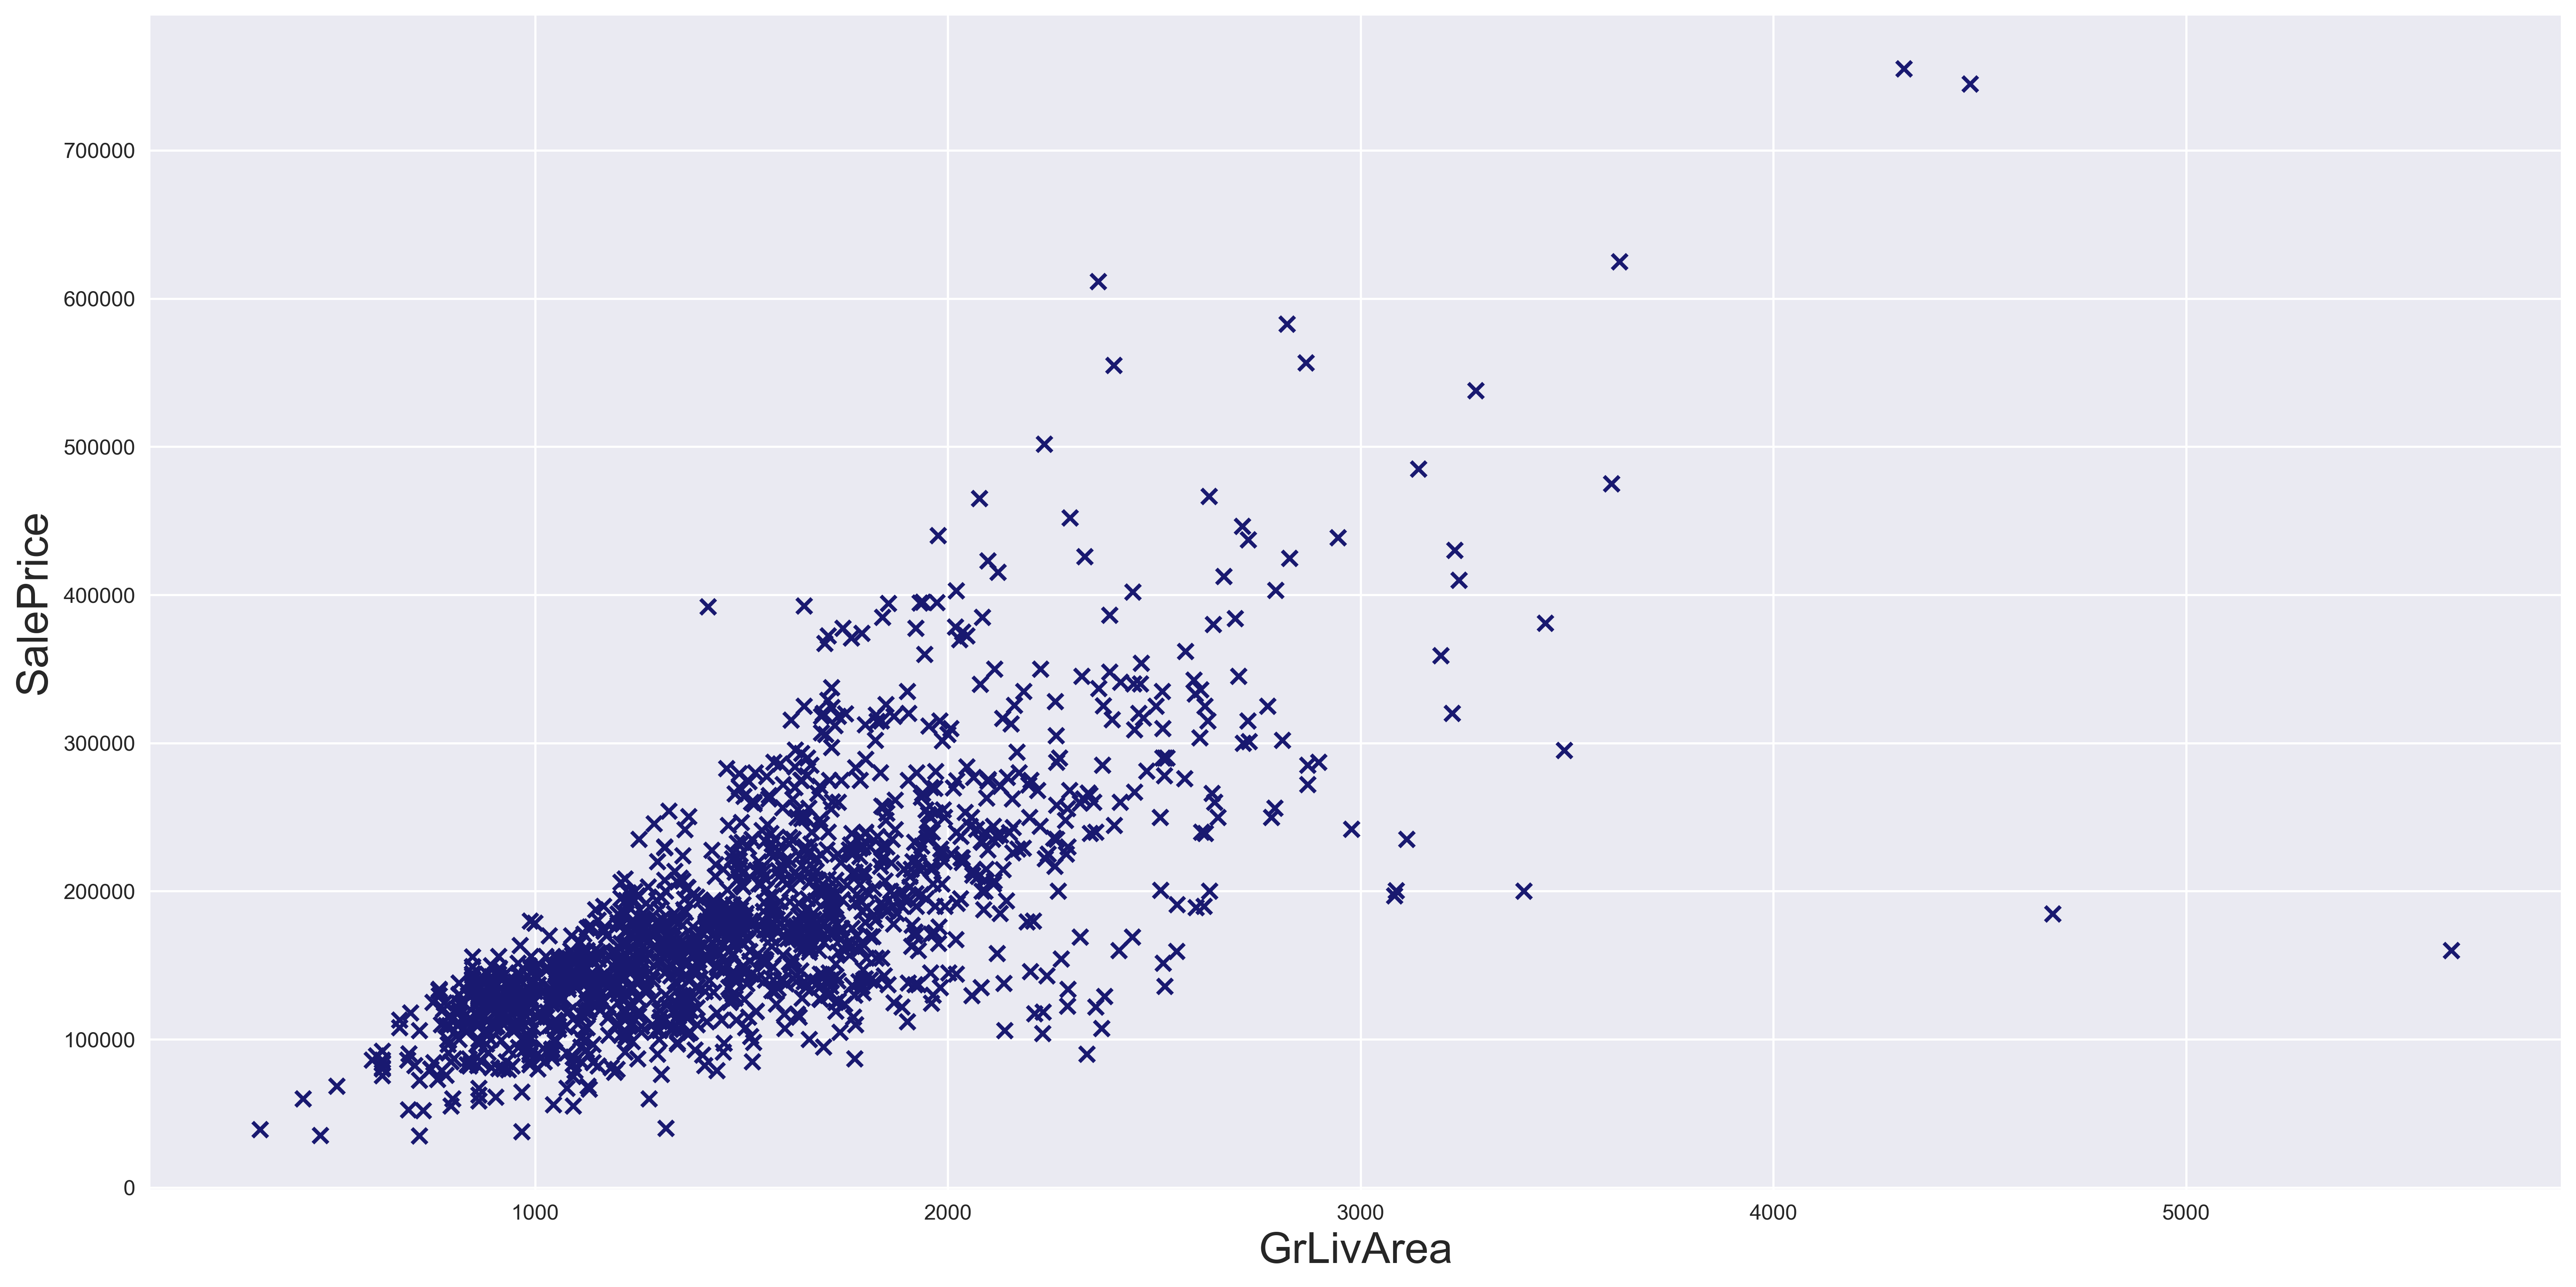

In [3]:
figure(num=1, figsize=(20, 10), dpi=369, facecolor='w', edgecolor='k')
fig1 = plt.scatter(train["GrLivArea"], train["SalePrice"], marker = 'x', color = 'midnightblue')
plt.xlabel("GrLivArea", fontsize=20)
plt.ylabel("SalePrice", fontsize = 20)

plt.show()

In [4]:
## Check the amount of records with GrLivArea > 4500 
outlier_byarea = train[train["GrLivArea"]> 4500].index

train = train.drop(train.index[outlier_byarea])

## Interestingly only two records are above the 4500 range we may suggest there is probably less than 2 outliers in this data set so we set the outlier_fraction in the PyOD outlier detection as 0.005

## Before running the Outlier Identification algorithm in PyOD
* Use MinMaxScaler to scale data between 0 and 1 since we are working with euclidean distance clustering methods


In [5]:
train['GrLivArea2'] = train['GrLivArea']
train['SalePrice2'] = train['SalePrice']


In [6]:
minmax = MinMaxScaler(feature_range=(0, 1))

train[['GrLivArea2', 'SalePrice2']] = minmax.fit_transform(train[['GrLivArea2', 'SalePrice2']])

# Using PyOD outlier removal, without defining the clustering method CBLOF uses K-means as its default

OUTLIERS: 3 INLIERS: 1455


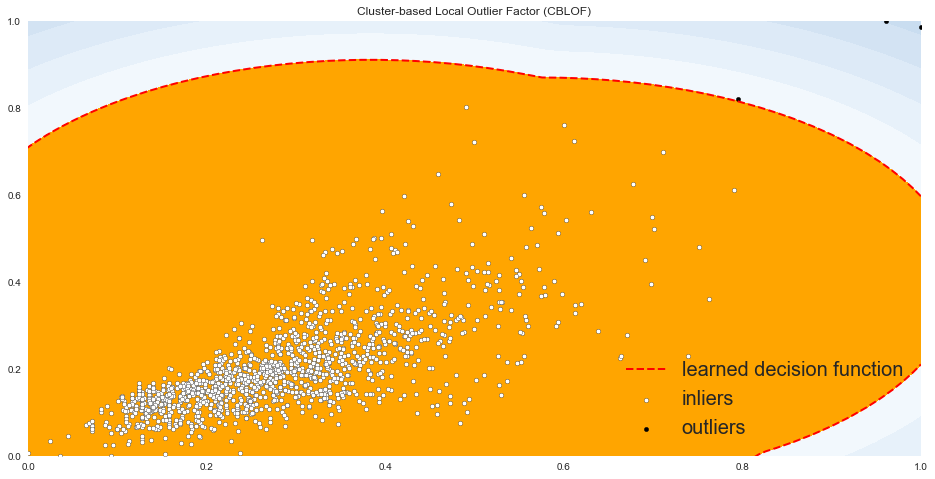

In [7]:
from pyod.models.cblof import CBLOF
X = train[['GrLivArea2', 'SalePrice2']].values
outlier_fraction = 0.0014
xx , yy = np.meshgrid(np.linspace(-1, 1,100), np.linspace(-1, 1,100))
clf = CBLOF(contamination=outlier_fraction,check_estimator=False, random_state=0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize=(16, 8))


train['outlier'] = y_pred.tolist()

# sales - inlier feature 1,  profit - inlier feature 2
inliers_liv = np.array(train['GrLivArea2'][train['outlier'] == 0]).reshape(-1,1)
inliers_price = np.array(train['SalePrice2'][train['outlier'] == 0]).reshape(-1,1)

# sales - outlier feature 1, profit - outlier feature 2
outliers_liv = train['GrLivArea2'][train['outlier'] == 1].values.reshape(-1,1)
outliers_price = train['SalePrice2'][train['outlier'] == 1].values.reshape(-1,1)

print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
threshold = stats.scoreatpercentile(scores_pred,100 *outlier_fraction)

# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 20),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_liv, inliers_price, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_liv, outliers_price, c='black',s=20, edgecolor='black')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show();

In [8]:
outlier_index = train.loc[train['outlier'] == 1].index
outlier_index

Int64Index([691, 1169, 1182], dtype='int64')

In [9]:
train[train.index.isin(outlier_index)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,GrLivArea2,SalePrice2,outlier
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,1,2007,WD,Normal,755000,0.961371,1.000000,1
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,7,2006,WD,Normal,625000,0.795027,0.819470,1
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,7,2007,WD,Abnorml,745000,1.000000,0.986113,1


### To be fair records 691 and 1182 seem quite reasonable since the sale price is high and GrLivArea is relatively high. However note that the record 1298 is quite weird. We see that the sale price is relatively low for such a large house and we can conclude that this is the only one that we want to be removing. We can come back to this after working with the predictions

In [10]:
outlier_index = pd.Index([1298], dtype = 'int64')
outlier_list = outlier_index.tolist()

In [11]:
# Lets drop the 1298 observation in the training data
train = train.drop(train.index[outlier_list])

# After doing some predictions and reading some others' opinions on Outliers
* it may be necessary to remove the two points greater than 4500 in GrLivArea
* records 1299 and 524 can heavily affect the data 


In [12]:
len(train["Id"].value_counts()) #unqiue 1458
len(train) #1459

len(test["Id"].value_counts()) #1459
len(test) #1459

#drop id since they are just like the index column 
train = train.drop("Id", axis =1)
test = test.drop("Id", axis = 1)

In [13]:
#orginal_index = train["SalePrice"].reset_index(drop = True) 
#drop parameter in reset index avoids the old index being added as a column

# lets not take the usual approach in dropping SalePrice and concat the test set by filling the SalePrice column with NaNs
#df_train = train.drop("SalePrice", axis = 1)
# we must drop the rows that we have newly created for the Outlier Identification process
df_train = train.drop('GrLivArea2', axis = 1)
df_train = df_train.drop('SalePrice2', axis = 1)
df_train = df_train.drop('outlier', axis = 1)



In [14]:
df_train = train
df_test = test
df_full = pd.concat([df_train,df_test], axis = 0, sort = False).reset_index(drop = True)

## Data Transformation
* Why do we transform the response variable? From my understanding it would just be easier for me since a lot of the models used for regression assumes an normally distrbuted response variable, but if we use some other GAM model this won't necessarily be true because it can easily be assuming a different distribution. 

* need not transform response variable at least for the moment
* The log or transformation of response y is based on seing heterescedasticrtity in residual plots.
* the histograms of response variables need not be close to normal. The assumption of MLR is that errors are normall distributed with a common variance. 
* this need not imply that the histogram of respones(y) is normall distributed. 
* if there are many similar vectors of x's then the distribution of y's over this subset with simlar x vectors is close to normal

## But why do we make the predictor variable normal? It isn't a strict assumption but if we understood GLM we know that in a simple linear regression there exists a soft assumption of normally distrbuted dependent variable. It is also good to transform all the variables including the predictor variables to a normal distribution since most probablistic models assums some sort of gaussian distribution! 

In [17]:
df_full['SalePrice'] = np.log(df_full['SalePrice']+1)

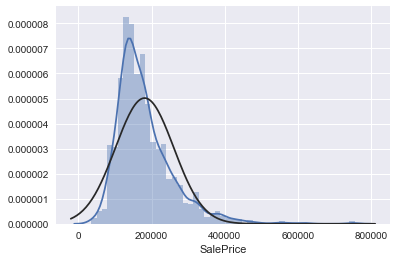

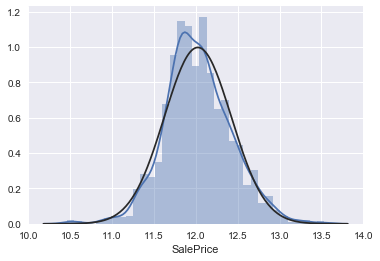

In [18]:
sns.distplot(train['SalePrice'], kde = True, fit = norm)
plt.show()
#right skewed response variable, can be fixed with a log transform
# we use the fit in scipy stats to observe and compare to the kde 

# suggested by Laurenstc we should log transform the Sale price variable 
sns.distplot(np.log(train['SalePrice']+1), kde=True, fit = norm)
plt.show()

# note that the x label is no longer the SalePrice but the log of SalePrice
# This is much more normal than it use to

# Observing Na's and Imputing data, we will observe each column one by one
* Most Na's can be filled with None, some we may fill with the media
* While some others may be filled with my personal assumptions and from reading the data description

In [19]:
# construct missing number of values for each column
df_na = df_full.isnull().sum()
df_na = df_na.drop(df_na[df_na ==0].index).sort_values(ascending =False)
df_na # this is seen as the number of rows of missing data

PoolQC          2907
MiscFeature     2811
Alley           2718
Fence           2345
outlier         1459
GrLivArea2      1459
SalePrice       1459
SalePrice2      1459
FireplaceQu     1420
LotFrontage      485
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Functional         2
Utilities          2
BsmtFullBath       2
BsmtFinSF2         1
BsmtUnfSF          1
BsmtFinSF1         1
TotalBsmtSF        1
Electrical         1
KitchenQual        1
GarageCars         1
Exterior2nd        1
Exterior1st        1
GarageArea         1
SaleType           1
dtype: int64

## Observing column PoolQC
* We observe three NaN's in PoolQC for the records that have PoolArea > 0 or in a sensse has a pool. (Three missing values should be imputed)
* We may want to imput the NaN's with some pior knowledge about the Quality and Condition of the property
* from Laurenstc's suggestion we impute based on the overal quality of the property
* However lets consider the both the overal quality and overal condition
* We also see that most of the missing PoolQC is in test data
### Note: 
* Ex	Excellent
* Gd	Good
* TA	Average/Typical
* Fa	Fair
* NA	No Pool

### From both observing the Overal Quality and Condition I decided to impute all of the missing values as Fair 
* I created an average value of overal quality and condition
* If we look caefully there is some what of a positive relationship between the pool quality and the average of overal condition and quality. 
* This is really subjective and I think I would impute all of them as fair since calculating the average of the records with missing values round to a value of 6. This is quite low considering the data we have seen below. 
* Also note that these records are fairly old two built in the 1950s and one in the 1980s, most likely not such great condition. 

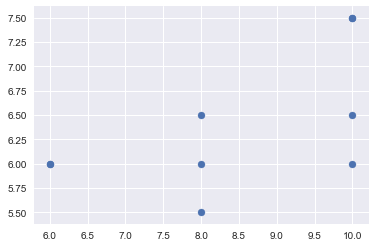

In [20]:
# we just set pool quality as excellent = 10, good = 8, fair = 6 
PoolQC_num = [10,6,8,10,6,8,10,10,8]
overalCond_num = [4,6,6,5,5,7,5,5,4]
overalQual_num = [8,6,6,10,7,6,10,8,7]
average_of_both = [6,6,6,7.5,6,6.5,7.5,6.5,5.5]
#plt.scatter(PoolQC_num , overalQual_num)
plt.scatter(PoolQC_num , average_of_both)
plt.show()

In [21]:
df_full[df_full['PoolArea'] > 0][['PoolQC', 'OverallCond', 'OverallQual', 'SalePrice']]
df_full.loc[2419, 'PoolQC'] = 'Fa'
df_full.loc[2502, 'PoolQC'] = 'Fa'
df_full.loc[2598, 'PoolQC'] = 'Fa'

In [22]:
df_full[df_full['PoolArea'] > 0]['PoolQC'].value_counts()

Ex    4
Gd    3
Fa    2
Name: PoolQC, dtype: int64

In [23]:
df_full["PoolQC"].sort_values()
# We see that there are Ex Fa and Gd
# we can fill all NaN's to None and act as the 4th categorical value
df_full["PoolQC"] = df_full["PoolQC"].fillna("None")
df_full['PoolQC'].value_counts()

None    2904
Fa         5
Ex         4
Gd         3
Name: PoolQC, dtype: int64

## MiscFeature, Alley, Fence, FireplaceQu
* MiscFeature: Miscellaneous feature not covered in other categories
* Alley: Type of alley access to property
* Fence: Fence quality
* FireplaceQu: Fireplace quality
### Alley
* I figure the type of alley access to property has something to do with the neighbourhood
* so lets try to impute based on the Neighbourhood


In [24]:
df_full.groupby(['Neighborhood', 'Alley']).count()

MSSubClass  MSZoning  LotFrontage  LotArea  Street  \
Neighborhood Alley                                                       
BrkSide      Pave            8         8            6        8       8   
Crawfor      Grvl            4         4            2        4       4   
Edwards      Grvl            9         9            9        9       9   
IDOTRR       Grvl           15        15           13       15      15   
             Pave            2         2            2        2       2   
NAmes        Grvl            2         2            2        2       2   
             Pave            1         1            0        1       1   
OldTown      Grvl           89        89           87       89      89   
             Pave           10        10            9       10      10   
SWISU        Grvl            1         1            1        1       1   
             Pave            5         5            5        5       5   
Somerst      Pave           52        52           49       52      52   

                    LotShape  LandContour  Utilities  LotConfig  LandSlope  \
Neighborhood Alley                                                           
BrkSide      Pave          8            8          8          8          8   
Crawfor      Grvl          4            4          4          4          4   
Edwards      Grvl          9            9          9          9          9   
IDOTRR       Grvl         15           15         15         15         15   
             Pave          2            2          2          2          2   
NAmes        Grvl          2            2          2          2          2   
             Pave          1            1          1          1          1   
OldTown      Grvl         89           89         89         89         89   
             Pave         10           10         10         10         10   
SWISU        Grvl          1            1          1          1          1   
             Pave          5            5          5          5          5   
Somerst      Pave         52           52         52         52         52   

                    ...  MiscFeature  MiscVal  MoSold  YrSold  SaleType  \
Neighborhood Alley  ...                                                   
BrkSide      Pave   ...            0        8       8       8         8   
Crawfor      Grvl   ...            0        4       4       4         4   
Edwards      Grvl   ...            1        9       9       9         9   
IDOTRR       Grvl   ...            0       15      15      15        15   
             Pave   ...            0        2       2       2         2   
NAmes        Grvl   ...            0        2       2       2         2   
             Pave   ...            0        1       1       1         1   
OldTown      Grvl   ...            6       89      89      89        89   
             Pave   ...            0       10      10      10        10   
SWISU        Grvl   ...            0        1       1       1         1   
             Pave   ...            1        5       5       5         5   
Somerst      Pave   ...            0       52      52      52        52   

                    SaleCondition  SalePrice  GrLivArea2  SalePrice2  outlier  
Neighborhood Alley                                                             
BrkSide      Pave               8          5           5           5        5  
Crawfor      Grvl               4          1           1           1        1  
Edwards      Grvl               9          6           6           6        6  
IDOTRR       Grvl              15          5           5           5        5  
             Pave               2          2           2           2        2  
NAmes        Grvl               2          1           1           1        1  
             Pave               1          0           0           0        0  
OldTown      Grvl              89         36          36          36       36  
             Pave              10      

### Lets fill all missing values in Oldtown with Grvl and all missing values in Somerst with Pave
* We do this since not much of the records have some value in the Alley column (Meaning a lot of NaN's)
* And we see that OldTown has majority Grvl and Somerst only has Pave valey. This probabiliy suggest that the neighborhood probably has similar alley types, but this is just speculation. 
* Lastly fill all the other NaN's with None 

In [25]:
# fill oldtown alley with Grvl

df_full.loc[df_full[(df_full['Neighborhood'] =='OldTown') & (df_full['Alley'].isnull())].index, 'Alley'] = 'Grvl'

In [26]:
# fill somerst alley with Pave
df_full.loc[df_full[(df_full['Neighborhood'] =='Somerst') & (df_full['Alley'].isnull())].index, 'Alley'] = 'Pave'

## Fill with None

In [27]:

df_full["MiscFeature"].sort_values()
df_full["MiscFeature"] = df_full["MiscFeature"].fillna("None")
df_full["Alley"] = df_full["Alley"].fillna("None")
df_full["Fence"] = df_full["Fence"].fillna("None")

df_full.loc[df_full[(df_full['Neighborhood'] =='Somerst') & (df_full['FireplaceQu'].isnull())].index, 'FireplaceQu'] = 'Gd'
df_full.loc[df_full[(df_full['Neighborhood'] =='NridgHt') & (df_full['FireplaceQu'].isnull())].index, 'FireplaceQu'] = 'Gd'
df_full.loc[df_full[(df_full['Neighborhood'] =='Crawfor') & (df_full['FireplaceQu'].isnull())].index, 'FireplaceQu'] = 'Gd'


df_full["FireplaceQu"] = df_full["FireplaceQu"].fillna("None")


In [28]:
df_full['KitchenQual'].value_counts()
# Even though the most popular Kitchen Quality is TA it isn't necessailry fair to impute everything else with TA
# Lets impute with Gd based on Neighborhood, since I checked the overall quality and condition and don't see any signifciant information to help me impute

TA    1492
Gd    1150
Ex     203
Fa      70
Name: KitchenQual, dtype: int64

In [29]:
df_full.loc[df_full[(df_full['Neighborhood'] =='Somerst') & (df_full['KitchenQual'].isnull())].index, 'KitchenQual'] = 'Gd'
df_full.loc[df_full[(df_full['Neighborhood'] =='CollgCr') & (df_full['KitchenQual'].isnull())].index, 'KitchenQual'] = 'Gd'
df_full.loc[df_full[(df_full['Neighborhood'] =='Gilbert') & (df_full['KitchenQual'].isnull())].index, 'KitchenQual'] = 'Gd'
df_full.loc[df_full[(df_full['Neighborhood'] =='NoRidge') & (df_full['KitchenQual'].isnull())].index, 'KitchenQual'] = 'Gd'

df_full.loc[df_full[(df_full['Neighborhood'] =='NridgHt') & (df_full['KitchenQual'].isnull())].index, 'KitchenQual'] = 'Gd'
df_full.loc[df_full[(df_full['Neighborhood'] =='SawyerW') & (df_full['KitchenQual'].isnull())].index, 'KitchenQual'] = 'Gd'
# Somerst, CollgCr, Gilbert, NoRidge, NridgHt,SawyerW fill with Good

# fill the rest of NaN's with TA
df_full["KitchenQual"] = df_full["KitchenQual"].fillna("TA")

In [30]:
# observe the value counts by neighborhoood
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(df_full.groupby(['Neighborhood', 'FireplaceQu']).count()['MSSubClass'])

# LotFrontage, Neighborhood

In [31]:
# fill the missing values with the median of the data
# since we can assume the linear feet of street connected to the property is similar by neighborhood 
# lot frontage: means that portion of a lot that abuts a public or private street. 
df_full["LotFrontage"] = df_full.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
df_full.groupby("Neighborhood")["LotFrontage"].median()

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    51.0
ClearCr    80.5
CollgCr    70.0
Crawfor    70.0
Edwards    64.5
Gilbert    64.0
IDOTRR     60.0
MeadowV    21.0
Mitchel    74.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    89.0
NridgHt    92.0
OldTown    60.0
SWISU      60.0
Sawyer     72.0
SawyerW    67.0
Somerst    72.5
StoneBr    60.0
Timber     82.0
Veenker    80.0
Name: LotFrontage, dtype: float64

# Garage

In [32]:
df_full[(df_full['GarageType'] == 'Detchd') & df_full['GarageYrBlt'].isnull()]['Neighborhood']

df_full.loc[2125, 'GarageYrBlt'] = df_full['GarageYrBlt'].median()
df_full.loc[2575, 'GarageYrBlt'] = df_full['GarageYrBlt'].median()

df_full.loc[2125, 'GarageFinish'] = df_full['GarageFinish'].mode()[0]
df_full.loc[2575, 'GarageFinish'] = df_full['GarageFinish'].mode()[0]

df_full.loc[2575, 'GarageCars'] = df_full['GarageCars'].median()

df_full.loc[2125, 'GarageArea'] = df_full['GarageArea'].median()
df_full.loc[2575, 'GarageArea'] = df_full['GarageArea'].median()

df_full.loc[2125, 'GarageQual'] = df_full['GarageQual'].mode()[0]
df_full.loc[2575, 'GarageQual'] = df_full['GarageQual'].mode()[0]

df_full.loc[2125, 'GarageCond'] = df_full['GarageCond'].mode()[0]
df_full.loc[2575, 'GarageCond'] = df_full['GarageCond'].mode()[0]

In [33]:
df_full["GarageType"] = df_full["GarageType"].fillna("None")
df_full["GarageFinish"] = df_full["GarageFinish"].fillna("None")
df_full["GarageQual"] = df_full["GarageQual"].fillna("None")
df_full["GarageCond"] = df_full["GarageCond"].fillna("None")

#fill with 0 since no garage => no GarageCars
df_full["GarageYrBlt"] = df_full["GarageYrBlt"].fillna(0)
df_full["GarageArea"] = df_full["GarageArea"].fillna(0)
df_full["GarageCars"] = df_full["GarageCars"].fillna(0)

In [34]:
df_full['GarageYrBlt'].head()

0    2003.0
1    1976.0
2    2001.0
3    1998.0
4    2000.0
Name: GarageYrBlt, dtype: float64

In [35]:
#there are quite a few more null values we need to fix
nulls = np.sum(df_full.isnull())
len(nulls[nulls != 0]) # 21 more we need to fix 
nulls[nulls != 0]

MSZoning           4
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
SaleType           1
SalePrice       1459
GrLivArea2      1459
SalePrice2      1459
outlier         1459
dtype: int64

In [36]:

#Only 4 missing 
np.sum(df_full["MSZoning"].isnull())
df_full["MSZoning"].value_counts()
#lets just fill the na's with RL since it is the most common 
df_full["MSZoning"] = df_full["MSZoning"].fillna("RL")

In [37]:
#Most common value is TA since only 1 observation is missing lets use it to fill the NaN
df_full["KitchenQual"].value_counts()
#df_full["KitchenQual"] =df_full["KitchenQual"].fillna("SBrkr")

TA    1493
Gd    1150
Ex     203
Fa      70
Name: KitchenQual, dtype: int64

In [38]:
#This does not help since the data is unbalance, may mess up training and holdout 
df_full["Utilities"].value_counts()
df_full = df_full.drop(['Utilities'], axis=1)

In [39]:
#Since only missing 1 observation fill with most common value
df_full['Exterior1st'] = df_full['Exterior1st'].fillna(df_full['Exterior1st'].mode()[0])
df_full['Exterior2nd'] = df_full['Exterior2nd'].fillna(df_full['Exterior2nd'].mode()[0])

In [40]:
df_full["MasVnrType"].value_counts()

None       1741
BrkFace     879
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64

In [41]:
#Na meaning no masonry veneer fill None and 0 
df_full["MasVnrType"] = df_full["MasVnrType"].fillna("None")
df_full["MasVnrArea"] = df_full["MasVnrArea"].fillna(0)

# Basement related variables

In [42]:
#In this case the missing values suggest that there is no basement 
nulls = np.sum(df_full.isnull())
nulls[nulls != 0]

BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
SaleType           1
SalePrice       1459
GrLivArea2      1459
SalePrice2      1459
outlier         1459
dtype: int64

In [43]:
#we fill with 0
for i in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df_full[i] = df_full[i].fillna(0)

In [44]:
#Observe the basement related columns
df_full[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF']].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
0,Gd,TA,No,GLQ,Unf,706.0,0.0,150.0,856.0
1,Gd,TA,Gd,ALQ,Unf,978.0,0.0,284.0,1262.0
2,Gd,TA,Mn,GLQ,Unf,486.0,0.0,434.0,920.0
3,TA,Gd,No,ALQ,Unf,216.0,0.0,540.0,756.0
4,Gd,TA,Av,GLQ,Unf,655.0,0.0,490.0,1145.0


In [45]:
#NaN in this case would mean no basement so we replace with none
for i in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_full[i] = df_full[i].fillna('None')

# Electrical, Functional and SaleType varialbe

In [46]:
nulls = np.sum(df_full.isnull())
nulls[nulls != 0]
#each of these aren't missing much data 

Electrical       1
Functional       2
SaleType         1
SalePrice     1459
GrLivArea2    1459
SalePrice2    1459
outlier       1459
dtype: int64

In [47]:
#since the electrical variable is only missing one observation we will replace with the most common observation,
#which is "SBrkr"
df_full['Electrical'] = df_full['Electrical'].fillna(df_full['Electrical'].mode()[0])

#As in the data description NA means Typical, which is Typ
df_full["Functional"] = df_full['Functional'].fillna("Typ")

#Fill in with the most frequent SaleType since only missing one observation
df_full['SaleType'] = df_full['SaleType'].fillna(df_full['SaleType'].mode()[0])

In [48]:
nulls = np.sum(df_full.isnull())
nulls[nulls != 0]
#We have filled in all the NA's 

SalePrice     1459
GrLivArea2    1459
SalePrice2    1459
outlier       1459
dtype: int64

In [49]:
df_full.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'O

# Change Numerical variables to Categorical

In [50]:
df_full['MSSubClass'] = df_full['MSSubClass'].apply(str)
df_full['OverallCond'] = df_full['OverallCond'].astype(str)
df_full['YrSold'] = df_full['YrSold'].astype(str)
df_full['MoSold'] = df_full['MoSold'].astype(str)



In [51]:
# Create new variable as total are of the house, which is just summing up the basement, 1st, and 2nd floor.
df_full['TotalSF'] = df_full['TotalBsmtSF'] + df_full['1stFlrSF'] + df_full['2ndFlrSF']

In [52]:
from sklearn.preprocessing import LabelEncoder
variables = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for v in variables:
    labels = LabelEncoder() 
    labels.fit(list(df_full[v].values)) 
    df_full[v] = labels.transform(list(df_full[v].values))

# shape        
print('Shape all_data: {}'.format(df_full.shape))


#Encode labels for future prediction use of categorical variables

Shape all_data: (2916, 83)


# Incorrect Data

In [53]:
pd.set_option('display.max_columns', None)
df_full.describe()
#Lets observe all the values to see if there is something weird

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SalePrice,GrLivArea2,SalePrice2,outlier,TotalSF
count,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.00000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,1457.000000,1457.000000,1457.000000,1457.000000,2916.000000
mean,7.131344,69.437929,10139.225652,0.995885,0.982167,1.948903,0.053841,6.086077,4.565158,1971.278464,1984.243141,100.848080,2.532579,3.708505,2.701989,3.673868,2.328189,3.184156,438.777435,5.549383,49.616255,560.598422,1048.992112,1.535322,0.932785,1157.744856,335.641289,4.699246,1498.085391,0.429012,0.061385,1.567215,0.379630,2.860082,1.044582,2.348765,6.447188,5.759602,0.596022,3.031893,1870.252743,1.87620,1.765775,472.331962,4.689300,4.765432,1.830590,93.661523,47.296296,23.122085,2.604938,16.078875,2.089506,2.991427,3.493141,50.878258,6.512689,1.792524,2.566309,0.283955,0.202753,0.002059,2542.378258
std,3.699367,21.211641,7808.366995,0.064029,0.400288,1.409522,0.248872,1.406844,1.113556,30.287835,20.894053,178.006092,0.699401,0.773983,1.294934,0.977421,1.151168,2.236000,444.231583,1.274084,169.258662,439.744413,429.543655,1.742749,0.250438,385.319993,428.027825,46.420449,496.912719,0.523973,0.245726,0.552501,0.502737,0.823104,0.214568,0.832510,1.563835,0.935755,0.644841,1.163781,449.902224,1.20153,0.762101,214.760754,0.950671,0.800419,0.537548,126.542458,67.124763,64.273020,25.200989,56.210905,34.567277,0.142009,1.091816,567.691765,2.984151,1.315363,0.030685,0.122622,0.110421,0.045345,781.167350
min,0.000000,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.438886,0.000000,0.000000,0.000000,334.000000
25%,5.000000,60.000000,7475.000000,1.000000,1.000000,0.000000,0.000000,5.000000,4.000000,1953.000000,1965.000000,0.000000,2.000000,4.000000,2.000000,4.000000,2.000000,2.000000,0.000000,6.000000,0.000000,220.000000,792.750000,0.000000,1.000000,876.000000,0.000000,0.000000,1125.750000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,2.000000,5.000000,6.000000,0.000000,2.000000,1957.000000,1.00000,1.000000,320.000000,5.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,5.000000,1.000000,2.547453,0.191695,0.131926,0.000000,2000.000000
50%,5.000000,70.000000,9451.000000,1.000000,1.000000,3.000000,0.000000,6.000000,4.000000,1973.000000,1993.000000,0.000000,3.000000,4.000000,2.000000,4.000000,3.000000,2.0

In [54]:
df_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,GrLivArea2,SalePrice2,outlier,TotalSF
0,10,RL,65.0,8450,1,1,3,Lvl,Inside,0,CollgCr,Norm,Norm,1Fam,2Story,7,4,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,2,4,PConc,2,4,3,2,706.0,6,0.0,150.0,856.0,GasA,0,1,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,2,8,6,0,3,Attchd,2003.0,2,2.0,548.0,5,5,2,0,61,0,0,0,0,3,4,None,0,4,2,WD,Normal,2.583824,0.332207,0.241078,0.0,2566.0
1,5,RL,80.0,9600,1,1,3,Lvl,FR2,0,Veenker,Feedr,Norm,1Fam,1Story,6,7,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,4,CBlock,2,4,1,0,978.0,6,0.0,284.0,1262.0,GasA,0,1,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,6,1,5,Attchd,1976.0,2,2.0,460.0,5,5,2,298,0,0,0,0,0,3,4,None,0,7,1,WD,Normal,2.573300,0.224046,0.203583,0.0,2524.0
2,10,RL,68.0,11250,1,1,0,Lvl,Inside,0,CollgCr,Norm,Norm,1Fam,2Story,7,4,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,2,4,PConc,2,4,2,2,486.0,6,0.0,434.0,920.0,GasA,0,1,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,2,6,6,1,5,Attchd,2001.0,2,2.0,608.0,5,5,2,0,42,0,0,0,0,3,4,None,0,11,2,WD,Normal,2.589054,0.350555,0.261908,0.0,2706.0
3,11,RL,60.0,9550,1,1,0,Lvl,Corner,0,Crawfor,Norm,Norm,1Fam,2Story,7,4,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,4,BrkTil,4,1,3,0,216.0,6,0.0,540.0,756.0,GasA,2,1,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,2,7,6,1,2,Detchd,1998.0,3,3.0,642.0,5,5,2,0,35,272,0,0,0,3,4,None,0,4,0,WD,Abnorml,2.553297,0.333897,0.145952,0.0,2473.0
4,10,RL,84.0,14260,1,1,0,Lvl,FR2,0,NoRidge,Norm,Norm,1Fam,2Story,8,4,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,2,4,PConc,2,4,0,2,655.0,6,0.0,490.0,1145.0,GasA,0,1,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,2,9,6,1,5,Attchd,2000.0,2,3.0,836.0,5,5,2,192,84,0,0,0,0,3,4,None,0,3,2,WD,Normal,2.597433,0.450024,0.298709,0.0,3343.0


# Change YearBuilt, YearRemodAdd and GarageYrBlt
* I think it makes more sense to change these into ages

In [55]:
df_full[df_full["GarageYrBlt"] == 2207]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,GrLivArea2,SalePrice2,outlier,TotalSF
2589,5,RL,68.0,8298,1,1,0,HLS,Inside,0,Timber,Norm,Norm,1Fam,1Story,8,4,2006,2007,Hip,CompShg,VinylSd,VinylSd,None,0.0,2,4,PConc,2,4,0,2,583.0,6,0.0,963.0,1546.0,GasA,0,1,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,0,6,6,1,2,Attchd,2207.0,2,2.0,502.0,5,5,2,132,0,0,0,0,0,3,4,None,0,11,1,New,Partial,NaN,NaN,NaN,NaN,3110.0


In [56]:
df_full[df_full["GarageYrBlt"] == 2207]
df_full.loc[2590, 'GarageYrBlt'] = 2007

In [57]:
import datetime
df_full["Age"] = datetime.datetime.now().year-df_full['YearBuilt'] 
df_full["RemodAge"] = datetime.datetime.now().year-df_full['YearRemodAdd']
df_full["GarageAge"] = datetime.datetime.now().year-df_full['GarageYrBlt']

## GarageYrBlt 
* The max is not correct it goes up to 2207
* this is most likely 2007 (an input error)


# Changing Data Types

In [58]:
type(df_full["MSSubClass"][1])
#this should be a factor instead of an integer

numpy.int64

In [59]:
type(df_full["MoSold"][1])

numpy.int64

In [60]:
#factors = ['MSSubClass', 'MoSold']
df_full.update(df_full["MoSold"].astype('str'))
df_full.update(df_full['MSSubClass'].astype('str'))

In [61]:
y_train = df_full.iloc[:len(train["SalePrice"]),:]
df_full = df_full.drop(['SalePrice'], axis =1 )

# Fixing skewness with data transformation (Box-Cox Tranform)

In [69]:
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

numerical_columns = list(df_full.select_dtypes(include=[np.number]).head().columns)
skewed_variables = df_full[numerical_columns].apply(lambda x: skew(x)).sort_values(ascending=False)
df_skewed = pd.DataFrame({'skew':skewed_variables})
df_skewed.head()

,skew
PoolArea,15.756794
3SsnPorch,8.920063
LowQualFinSF,8.739474
MiscVal,5.593914
LandSlope,4.529377


In [70]:
very_skewed = df_skewed[abs(df_skewed) > 0.5]
skewed_index = df_skewed.index

for i in skewed_index:
    df_full[i]= boxcox1p(df_full[i], 0.15)



# Dummy Categorical Variables using `pd.get_dummies` without specifying the parameters would just be the same thing as one hot encoding.


In [71]:
df_full = pd.get_dummies(df_full).reset_index(drop=True)
df_full.shape

(2916, 252)

# Back to Train and Test set

In [72]:
len(train["SalePrice"])

1457

In [73]:
X = df_full.iloc[:len(train["SalePrice"]),:]
X.shape

(1457, 252)

In [74]:
test_df= df_full.iloc[len(X):,:]
test_df.shape

(1459, 252)

In [98]:
np.all(np.isfinite(train["SalePrice"]))

True

In [99]:
np.any(np.isnan(train["SalePrice"]))

False

In [100]:
np.all(np.isfinite(X))

True

In [101]:
np.any(np.isnan(X)) # This is because of dummies

False

test_df = test_df.drop(['SalePrice'], axis = 1)
np.where(np.isnan(test_df))

In [102]:
nulls = np.sum(test_df.isnull())
len(nulls[nulls != 0]) # 21 more we need to fix 
nulls[nulls != 0]

GarageAge    1
dtype: int64

In [105]:
test_df[test_df.GarageAge.isnull()]

,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,YrSold,TotalSF,Age,RemodAge,GarageAge,MSSubClass_0,MSSubClass_1,MSSubClass_10,MSSubClass_11,MSSubClass_12,MSSubClass_13,MSSubClass_14,MSSubClass_15,MSSubClass_2,MSSubClass_3,MSSubClass_4,MSSubClass_5,MSSubClass_6,MSSubClass_7,MSSubClass_8,MSSubClass_9,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_0,MoSold_1,MoSold_10,MoSold_11,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
2590,5.91494,19.141824,0.730463,0.730463,0.0,0.0,2.602594,1.820334,14.192207,14.193765,0.0,1.194318,1.820334,1.194318,1.820334,0.0,1.194318,10.666211,2.259674,0.0,12.019503,13.393396,0.0,0.730463,13.428235,0

Seems like our X and y both seems fine so we can proceed

# Add the price column back on the train set

In [134]:
X.to_csv("X.csv", index = False)
y_train= y_train['SalePrice']
y_train.to_csv("y.csv", index = False, header = ['SalePrice'])


In [135]:
test_df.to_csv("test_cleaned.csv", index = False)